In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
# import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack
# import fitsio

from astropy import units as u
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.stats import binned_statistic

sys.path.append('/Users/rongpu/git/Python/user_modules/')
from user_common import extrap1d

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
sed_reorder = [2, 3, 4, 6, 5, 7, 1]

In [4]:
# # Filter curves from Legacy Surveys website
# bands = ['decam_g', 'decam_r', 'decam_z']
# filenames = ['decam.g.am1p4.dat.txt', 'decam.r.am1p4.dat.txt', 'decam.z.am1p4.dat.txt']
# plt.figure(figsize=(12, 10))
# for index in range(len(bands)):
#     band = bands[index]
#     # Load filter response curve
#     filename = filenames[index]
#     tmp = Table.read('/Users/rongpu/Data/desi_misc/extinction/filter_curves/'+filename, format='ascii')
#     wx = tmp['col1']
#     if 'decam' or 'mosaic' in band:
#         wy = tmp['col2']
#     else:
#         wy = tmp['col4']
#     plt.plot(wx, wy)
# plt.show()

In [5]:
# # Filter curves from EAZY
# bands = ['u', 'g', 'r', 'i', 'z', 'y']
# filters = {}
# for index in range(len(bands)):
#     band = bands[index]
#     tmp = Table.read('/Users/rongpu/Data/desi_misc/extinction/filter_curves/EAZY/DECam_{}.txt'.format(band), format='ascii.no_header')
#     wx = tmp['col2']
#     wy = tmp['col3']
#     # Interpolate filter response curve
#     filters[band] = extrap1d(wx, wy)
# plt.figure(figsize=(12, 10))
# plt.plot([], [], ' ', color='k', label="            R(g)     R(r)    R(z)")
# for index in range(len(bands)):
#     band = bands[index]
#     wx = np.linspace(3000, 11000, 2000)
#     plt.plot(wx, filters[band](wx))
# plt.show()

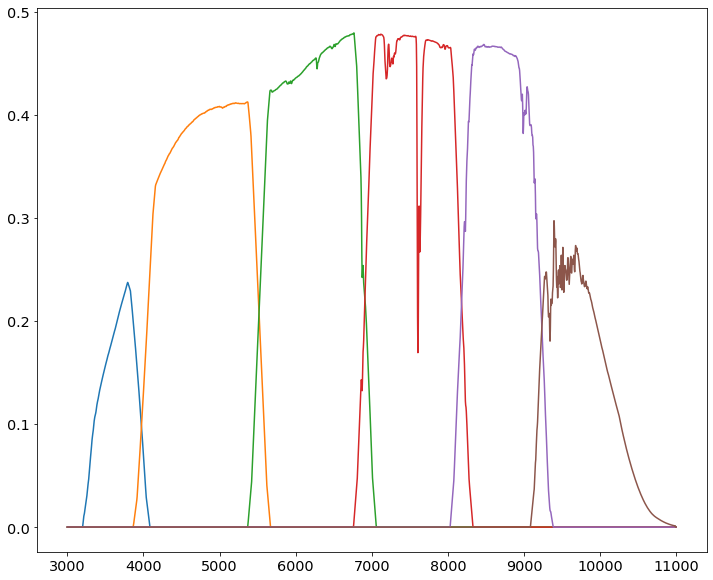

In [6]:
# Filter curves from https://github.com/lsst/throughputs/blob/main/baseline
bands = ['u', 'g', 'r', 'i', 'z', 'y']
filters = {}
for index in range(len(bands)):
    band = bands[index]
    tmp = Table.read('/Users/rongpu/Downloads/throughputs-main/baseline/total_{}.dat'.format(band), format='ascii.no_header')
    wave = tmp['col1'] * 10.  # nm -> angstrom
    throughput = tmp['col2']
    # Interpolate filter response curve
    filters[band] = extrap1d(wave, throughput)

plt.figure(figsize=(12, 10))
plt.plot([], [], ' ', color='k', label="            R(g)     R(r)    R(z)")
for index in range(len(bands)):
    band = bands[index]
    wave = np.linspace(3000, 11000, 2000)
    plt.plot(wave, filters[band](wave))
plt.show()

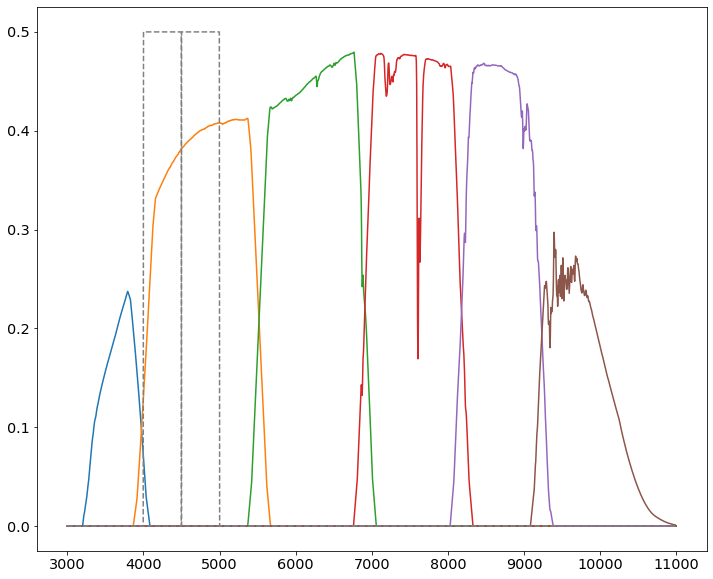

In [30]:
# Add medium band filters
wave = np.linspace(3000, 11000, 2000)
throughput = np.zeros(len(wave))
mask = (wave>=4000) & (wave<=4500)
throughput[mask] = 0.5
filters['gm1'] = extrap1d(wave, throughput)
throughput = np.zeros(len(wave))
mask = (wave>=4500) & (wave<=5000)
throughput[mask] = 0.5
filters['gm2'] = extrap1d(wave, throughput)

bands = ['u', 'g', 'r', 'i', 'z', 'y', 'gm1', 'gm2']
plt.figure(figsize=(12, 10))
for index in range(len(bands)):
    band = bands[index]
    wave = np.linspace(3000, 11000, 2000)
    if band[:2]=='gm':
        plt.plot(wave, filters[band](wave), ls='--', color='0.5')
    else:
        plt.plot(wave, filters[band](wave))
plt.show()

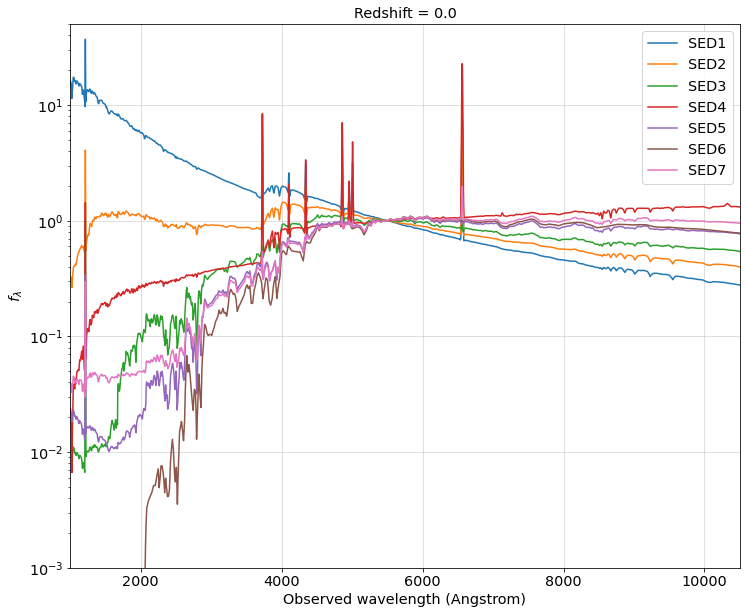

In [8]:
redshift = 0

seds = {}
for sed_index in range(1, 8):
    # Galaxy spectrum f_lambda (in flux unit)
    fn = '/Users/rongpu/Data/desi_misc/extinction/templates/EAZY_v1.1_lines/eazy_v1.1_sed{}.dat'.format(sed_reorder[sed_index-1])
    tmp = Table.read(fn, format='ascii')
    wave, f_lambda = tmp['col1'], tmp['col2']    
    mask = (wave>1000) & (wave<11000)
    wave = wave[mask]
    f_lambda = f_lambda[mask]
    s_interp = extrap1d(wave, f_lambda)
    seds['SED{}'.format(sed_index)] = s_interp
    
plt.figure(figsize=(12, 10))
for sed_index in range(1, 8):
    wave = np.linspace(1000, 11000, 10001)
    f_lambda = seds['SED{}'.format(sed_index)](wave)
    f_norm = seds['SED{}'.format(sed_index)](5500)
    f_lambda = f_lambda/f_norm
    plt.plot(wave, f_lambda, label='SED{}'.format(sed_index))

# plt.plot(smooth_sx_star, smooth_sy_star, 'gray', linewidth=5, alpha=0.6, label='7000K star')
plt.title('Redshift = {:.1f}'.format(redshift))
plt.xlabel('Observed wavelength (Angstrom)')
plt.ylabel('$f_\lambda$')

plt.xlim(1000, 10500)
plt.ylim(1e-3, 5e1)
plt.yscale('log')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [90]:
redshifts = np.arange(0., 0.16, 0.002)

cat = Table()
cat['redshift'] = redshifts

for sed_index in range(1, 8):

    for band in bands:
        print('SED{} {}'.format(sed_index, band))
        mags = []
        for redshift_index, redshift in enumerate(redshifts):
            integrand = lambda wave: filters[band](wave) * seds['SED{}'.format(sed_index)](wave / (1+redshift)) * wave**2
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                flux = quad(integrand, wave.min(), wave.max())[0] / quad(filters[band], wave.min(), wave.max())[0]
            mags.append(-2.5 * np.log10(flux))
        cat['SED{}_{}'.format(sed_index, band)] = mags

SED1 u
SED1 g
SED1 r
SED1 i
SED1 z
SED1 y
SED1 gm1
SED1 gm2
SED2 u
SED2 g
SED2 r
SED2 i
SED2 z
SED2 y
SED2 gm1
SED2 gm2
SED3 u
SED3 g
SED3 r
SED3 i
SED3 z
SED3 y
SED3 gm1
SED3 gm2
SED4 u
SED4 g
SED4 r
SED4 i
SED4 z
SED4 y
SED4 gm1
SED4 gm2
SED5 u
SED5 g
SED5 r
SED5 i
SED5 z
SED5 y
SED5 gm1
SED5 gm2
SED6 u
SED6 g
SED6 r
SED6 i
SED6 z
SED6 y
SED6 gm1
SED6 gm2
SED7 u
SED7 g
SED7 r
SED7 i
SED7 z
SED7 y
SED7 gm1
SED7 gm2


In [98]:
cat.write('/Users/rongpu/Downloads/synth_colors.fits')

In [ ]:
cat = Table(fitsio.read('/Users/rongpu/Downloads/synth_colors.fits'))

In [147]:
tt = cat.copy()

for sed_index in range(1, 8):
    for band in bands:
        tt.remove_column('SED{}_{}'.format(sed_index, band))
        tt.remove_column('SED{}_{}_flux'.format(sed_index, band))
        tt.remove_column('SED{}_{}_fluxerr'.format(sed_index, band))

tt.write('/Users/rongpu/Downloads/eazy_synth_colors.fits')

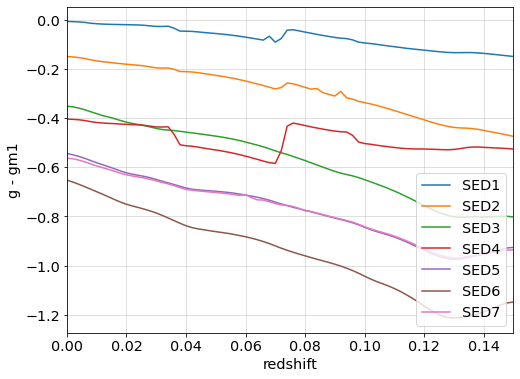

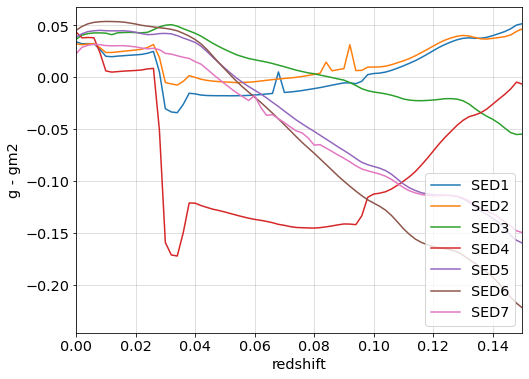

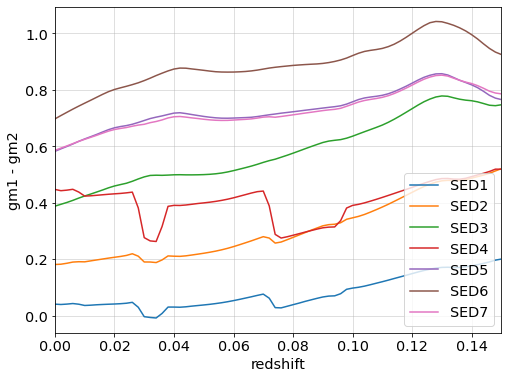

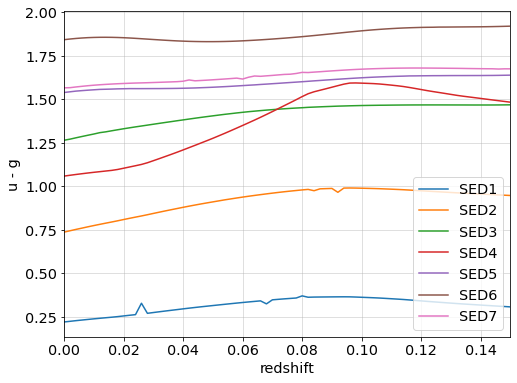

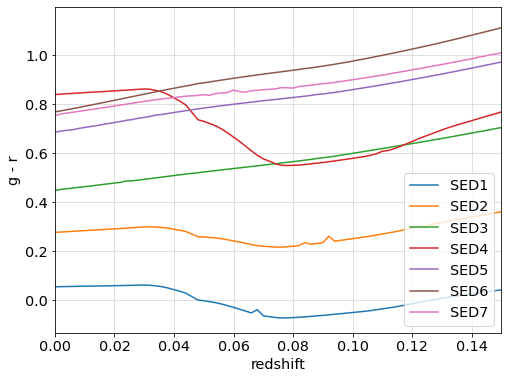

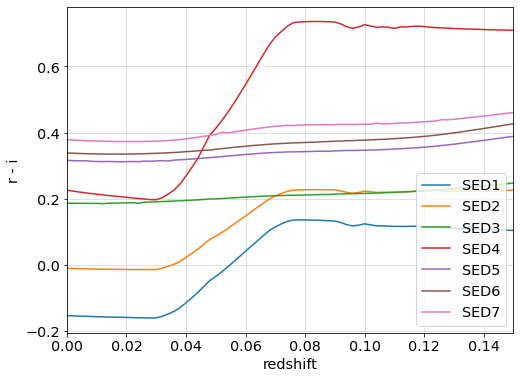

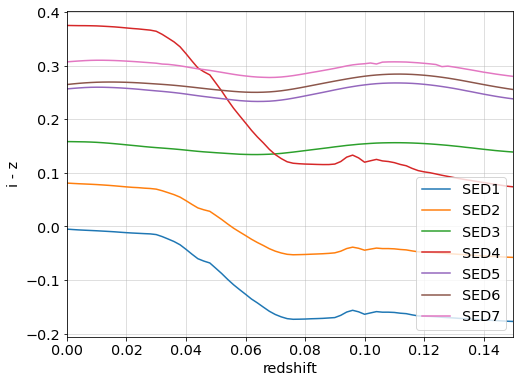

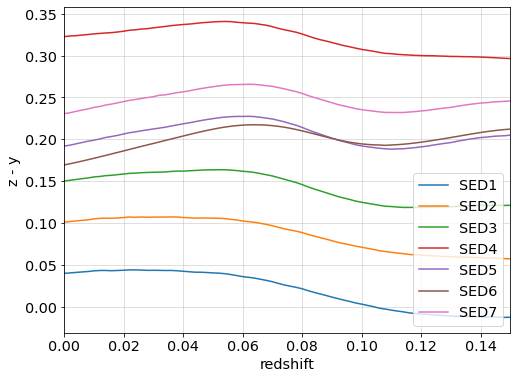

In [124]:
for color in [['g', 'gm1'], ['g', 'gm2'], ['gm1', 'gm2'], ['u', 'g'], ['g', 'r'], ['r', 'i'], ['i', 'z'], ['z', 'y']]:
    plt.figure(figsize=(8, 6))
    for sed_index in range(1, 8):
        plt.plot(cat['redshift'], cat['SED{}_{}'.format(sed_index, color[0])]-cat['SED{}_{}'.format(sed_index, color[1])], label='SED{}'.format(sed_index))
    plt.xlim(0, 0.15)
    plt.grid(alpha=0.5)
    plt.xlabel('redshift')
    plt.ylabel('{} - {}'.format(color[0], color[1]))
    plt.legend(loc='lower right')
    plt.show()

In [125]:
# https://arxiv.org/abs/1204.1210
relative_sky_brightness = {'u':23., 'g':22.5, 'gm1':22.5, 'gm2':22.5, 'r':21.5, 'i':20.5, 'z':18.75, 'y':18.75}

In [126]:
for sed_index in range(1, 8):
    mag_offset = cat['SED{}_r'.format(sed_index)] - (21.5-3.25)  # set r band to be 20 times (3.25 mag) brighter than sky
    for band in ['u', 'g', 'gm1', 'gm2', 'r', 'i', 'z', 'y']:
        cat['SED{}_{}_flux'.format(sed_index, band)] = 10**(-0.4*(cat['SED{}_{}'.format(sed_index, band)]-mag_offset))
        cat['SED{}_{}_fluxerr'.format(sed_index, band)] = 10**(-0.4*(relative_sky_brightness[band]))
        cat['SED{}_{}_mag'.format(sed_index, band)] = -2.5*np.log10(cat['SED{}_{}_flux'.format(sed_index, band)])
        cat['SED{}_{}_magerr'.format(sed_index, band)] = cat['SED{}_{}_fluxerr'.format(sed_index, band)]/cat['SED{}_{}_flux'.format(sed_index, band)]

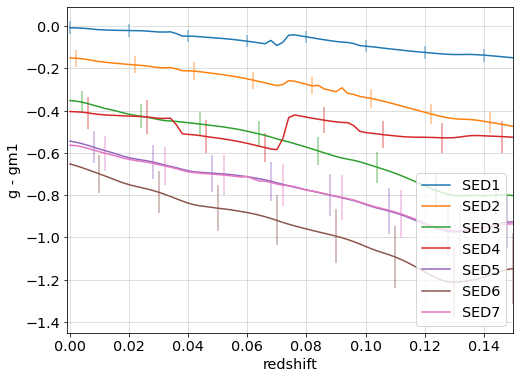

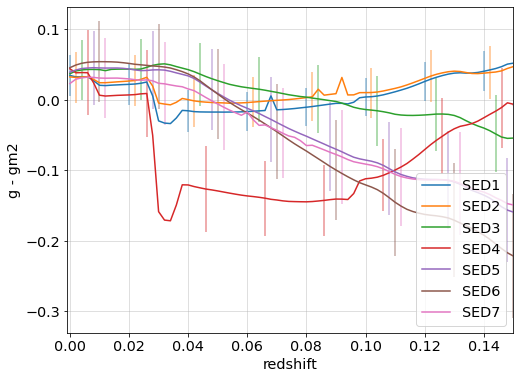

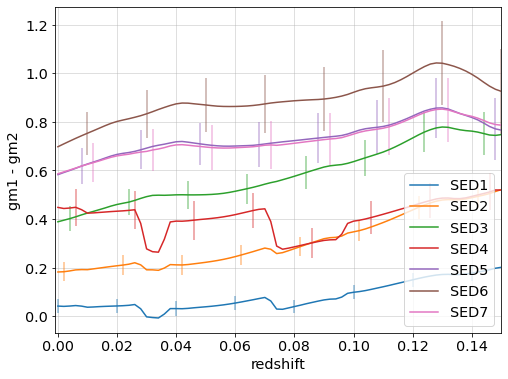

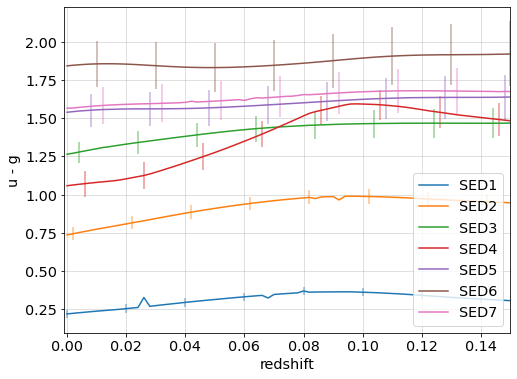

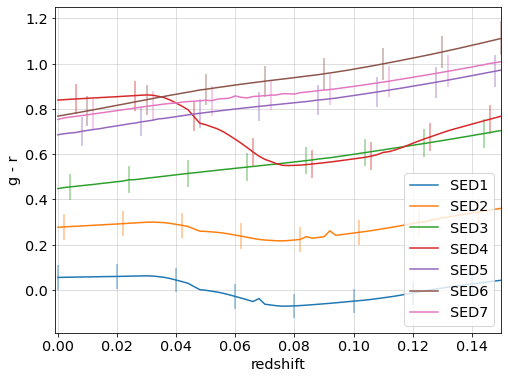

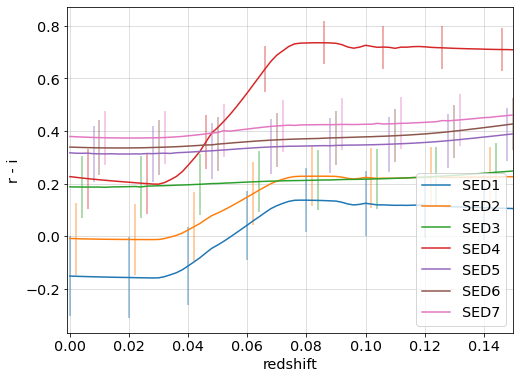

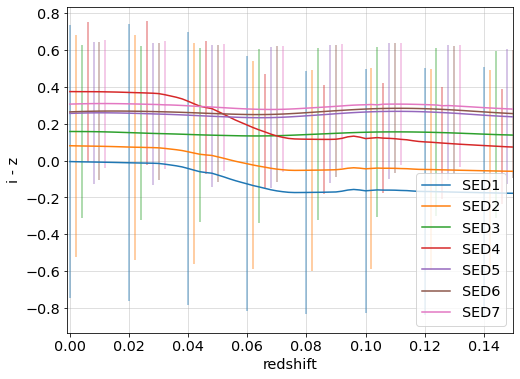

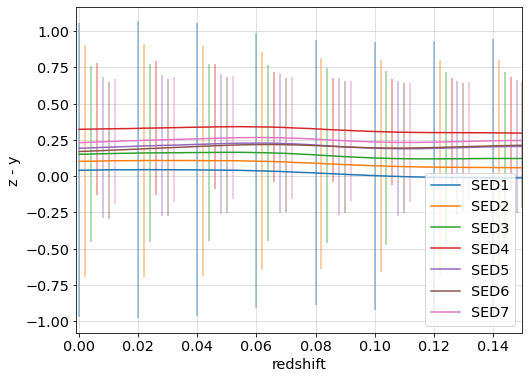

In [127]:
for color in [['g', 'gm1'], ['g', 'gm2'], ['gm1', 'gm2'], ['u', 'g'], ['g', 'r'], ['r', 'i'], ['i', 'z'], ['z', 'y']]:
    plt.figure(figsize=(8, 6))
    for sed_index in range(1, 8):
        plt.plot(cat['redshift'], cat['SED{}_{}_mag'.format(sed_index, color[0])]-cat['SED{}_{}_mag'.format(sed_index, color[1])], label='SED{}'.format(sed_index), color='C'+str(sed_index-1))
        plt.errorbar(cat['redshift'][sed_index-1:][::10], (cat['SED{}_{}_mag'.format(sed_index, color[0])]-cat['SED{}_{}_mag'.format(sed_index, color[1])])[sed_index-1:][::10], yerr=np.sqrt(cat['SED{}_{}_magerr'.format(sed_index, color[0])]**2+cat['SED{}_{}_magerr'.format(sed_index, color[1])]**2)[sed_index-1:][::10], color='C'+str(sed_index-1), fmt='none', alpha=0.5)
    plt.xlim(-0.001, 0.15)
    plt.grid(alpha=0.5)
    plt.xlabel('redshift')
    plt.ylabel('{} - {}'.format(color[0], color[1]))
    plt.legend(loc='lower right')
    plt.show()

In [128]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('/Users/rongpu/Downloads/color_vs_redshift.pdf') as pdf:
    for color in [['g', 'gm1'], ['g', 'gm2'], ['gm1', 'gm2'], ['u', 'g'], ['g', 'r'], ['r', 'i'], ['i', 'z'], ['z', 'y']]:
        plt.figure(figsize=(8, 6))
        for sed_index in range(1, 8):
            plt.plot(cat['redshift'], cat['SED{}_{}_mag'.format(sed_index, color[0])]-cat['SED{}_{}_mag'.format(sed_index, color[1])], label='SED{}'.format(sed_index), color='C'+str(sed_index-1))
            plt.errorbar(cat['redshift'][sed_index-1:][::10], (cat['SED{}_{}_mag'.format(sed_index, color[0])]-cat['SED{}_{}_mag'.format(sed_index, color[1])])[sed_index-1:][::10], yerr=np.sqrt(cat['SED{}_{}_magerr'.format(sed_index, color[0])]**2+cat['SED{}_{}_magerr'.format(sed_index, color[1])]**2)[sed_index-1:][::10], color='C'+str(sed_index-1), fmt='none', alpha=0.5)
        plt.xlim(0, 0.15)
        plt.grid(alpha=0.5)
        plt.xlabel('redshift')
        plt.ylabel('{} - {}'.format(color[0], color[1]))
        plt.legend(loc='lower right')
        pdf.savefig()
        plt.close()

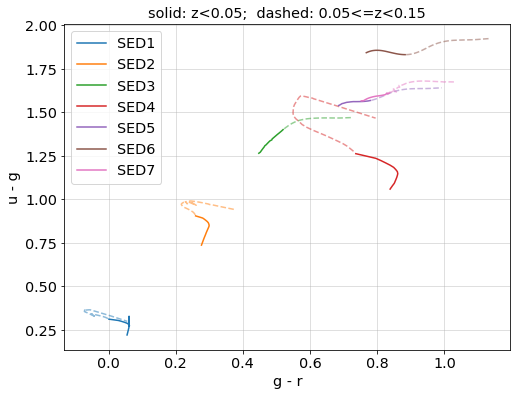

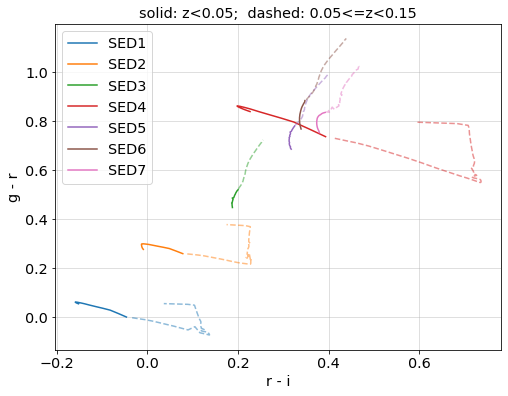

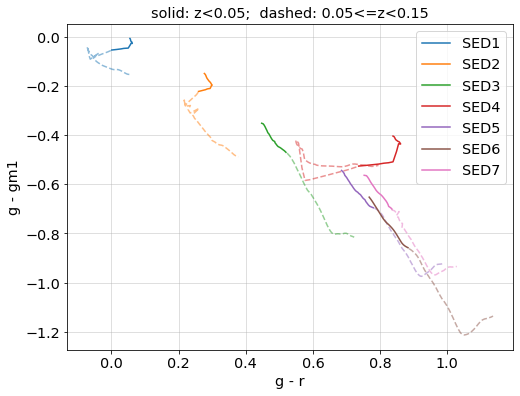

In [138]:
for twocolors in [[['u', 'g'], ['g', 'r']], [['g', 'r'], ['r', 'i']], [['g', 'gm1'], ['g', 'r']]]:
    color1, color2 = twocolors
    plt.figure(figsize=(8, 6))
    for sed_index in range(1, 8):
        mask = cat['redshift']<0.05
        plt.plot((cat['SED{}_{}'.format(sed_index, color2[0])]-cat['SED{}_{}'.format(sed_index, color2[1])])[mask], (cat['SED{}_{}'.format(sed_index, color1[0])]-cat['SED{}_{}'.format(sed_index, color1[1])])[mask],
                 label='SED{}'.format(sed_index), color='C'+str(sed_index-1), lw=1.5)
        plt.plot((cat['SED{}_{}'.format(sed_index, color2[0])]-cat['SED{}_{}'.format(sed_index, color2[1])])[~mask], (cat['SED{}_{}'.format(sed_index, color1[0])]-cat['SED{}_{}'.format(sed_index, color1[1])])[~mask],
                 ls='--', color='C'+str(sed_index-1), alpha=0.5, lw=1.5)
        plt.title('solid: z<0.05;  dashed: 0.05<=z<0.15')
    plt.grid(alpha=0.5)
    plt.xlabel('{} - {}'.format(color2[0], color2[1]))
    plt.ylabel('{} - {}'.format(color1[0], color1[1]))
    plt.legend(loc='best')
    plt.show()

In [137]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('/Users/rongpu/Downloads/color_vs_color.pdf') as pdf:
    for twocolors in [[['u', 'g'], ['g', 'r']], [['g', 'r'], ['r', 'i']], [['g', 'gm1'], ['g', 'r']]]:
        color1, color2 = twocolors
        plt.figure(figsize=(8, 6))
        for sed_index in range(1, 8):
            mask = cat['redshift']<0.05
            plt.plot((cat['SED{}_{}'.format(sed_index, color2[0])]-cat['SED{}_{}'.format(sed_index, color2[1])])[mask], (cat['SED{}_{}'.format(sed_index, color1[0])]-cat['SED{}_{}'.format(sed_index, color1[1])])[mask],
                     label='SED{}'.format(sed_index), color='C'+str(sed_index-1), lw=1.5)
            plt.plot((cat['SED{}_{}'.format(sed_index, color2[0])]-cat['SED{}_{}'.format(sed_index, color2[1])])[~mask], (cat['SED{}_{}'.format(sed_index, color1[0])]-cat['SED{}_{}'.format(sed_index, color1[1])])[~mask],
                     ls='--', color='C'+str(sed_index-1), alpha=0.5, lw=1.5)
            plt.title('solid: z<0.05;  dashed: 0.05<=z<0.15')
        plt.grid(alpha=0.5)
        plt.xlabel('{} - {}'.format(color2[0], color2[1]))
        plt.ylabel('{} - {}'.format(color1[0], color1[1]))
        plt.legend(loc='best')
        pdf.savefig()
        plt.close()